In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit as fit
import array
import sys
sys.path.insert(0, '/Users/sdporzio/HighVoltageTask')
import HvPackages.probability as prob
from HvPackages.dataFunctions import GetDateString as GDS
from HvPackages.dataFunctions import GetTimeString as GTS

In [3]:
cutY = -150
leftLim = 1448148352 # 21 Nov
rightLim = 1454500456 # 3 Feb
nMonths = 2.4

fHV = open("Timestamps/hvBlipsFromData.dat")
fPMT = open("Timestamps/pmtHitsFromTorScopeMon.dat")
headerHV = fHV.readline()
headerPMT = fPMT.readline()

timeHV = array.array("d",[])
blipType = []
blipDuration = array.array("d",[])
blipIntensity = array.array("d",[])
originFilePMT = []
timePMT = array.array("d",[])
timeCutPMT = array.array("d",[])
min1PMT = array.array("d",[])
min2PMT = array.array("d",[])
min3PMT = array.array("d",[])
min4PMT = array.array("d",[])

for line in fHV:
    x = line.split()
    if float(x[0]) > leftLim and float(x[0]) < rightLim:
        timeHV.append(float(x[0]))
        blipType.append(x[1])
        blipIntensity.append(float(x[5]))
        blipDuration.append(float(x[6]))

for line in fPMT:
    x = line.split()
    if float(x[1]) > leftLim and float(x[1]) < rightLim:
        originFilePMT.append(x[0])
        timePMT.append(float(x[1]))
        min1PMT.append(float(x[2]))
        min2PMT.append(float(x[3]))
        min3PMT.append(float(x[4]))
        min4PMT.append(float(x[5]))
    
for i,timestampPMT in enumerate(timePMT):
    if min1PMT[i] < cutY and min2PMT[i] < cutY and min3PMT[i] < cutY and min4PMT[i] < cutY:
        timeCutPMT.append(float(timestampPMT))
        
nHV = len(timeHV)
nPMT = len(timeCutPMT)
print "%i HV events" %(nHV)
print "%i PMT events, after cut (%.f) [%i originally]" %(nPMT,cutY,len(timePMT))

115 HV events
100 PMT events, after cut (-150) [15395 originally]


In [4]:
tWindow = 30

timeC = array.array("d",[])
deltaC = array.array("d",[])

for i,timestampHV in enumerate(timeHV):
    for j,timestampPMT in enumerate(timeCutPMT):
        deltaT = timestampPMT-timestampHV
        if abs(deltaT) < tWindow:
            timeC.append(timestampHV)
            deltaC.append(deltaT)

nCoinc = len(timeC)
probability = prob.prob3(nMonths,tWindow,nHV,nPMT,nCoinc)*100
average = prob.average3(nMonths,tWindow,nHV,nPMT)

print "%i coincidences found with %.1f%% probability" %(nCoinc,probability)
print "Expected average with a %.fs time window: %.2f" %(tWindow,average)

2 coincidences found with 0.6% probability
Expected average with a 30s time window: 0.11


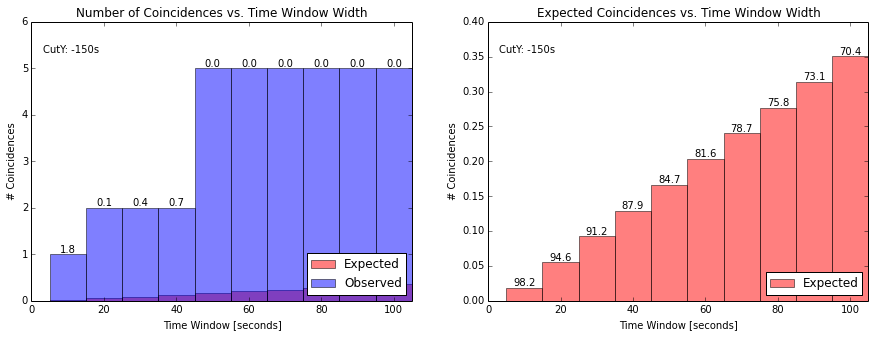

In [5]:
maxWindow = 100
step = 10

numC = array.array("I",[])
tWindow = array.array("d",[])
probC = array.array("d",[])
aveC = array.array("d",[])
probAveC = array.array("d",[])

for t in np.arange(5,maxWindow,step):
    timeC = array.array("d",[])
    deltaC = array.array("d",[])
    for i,timestampHV in enumerate(timeHV):
        for j,timestampPMT in enumerate(timeCutPMT):
            deltaT = timestampPMT-timestampHV
            if abs(deltaT) < t:
                timeC.append(timestampHV)
                deltaC.append(deltaT)

    nCoinc = len(timeC)
    average = prob.average3(nMonths,t,nHV,nPMT)
    tWindow.append(float(t))
    numC.append(nCoinc)
    probC.append(prob.prob3(nMonths,t,nHV,nPMT,nCoinc)*100)
    aveC.append(average)
    probAveC.append(prob.poissonian(average)*100)

fig = plt.figure(figsize=(15,5), dpi=80)
fig1 = fig.add_subplot(121)
fig1.bar(tWindow,aveC,step,color="red",alpha=0.5,label='Expected')
fig1.bar(tWindow,numC,step,color="blue",alpha=0.5,label='Observed')
for x,y,probs in zip(tWindow,numC,probC):
    fig1.text(x+step/2., y, '%.1f' %probs, ha='center', va= 'bottom')
fig1.text(.03, .9,"CutY: %.fs" %cutY, ha='left', va='center',fontsize=10,transform=fig1.transAxes)
fig1.legend(loc='lower right', frameon=True)
fig1.set_title("Number of Coincidences vs. Time Window Width")
plt.xlabel('Time Window [seconds]')
plt.ylabel('# Coincidences')
plt.ylim(0,max(numC)+1)
plt.xlim(0,maxWindow+step/2.)

fig2 = fig.add_subplot(122)
fig2.bar(tWindow,aveC,step,color="red",alpha=0.5,label='Expected')
for x,y,probs in zip(tWindow,aveC,probAveC):
    fig2.text(x+step/2., y, '%.1f' %probs, ha='center', va= 'bottom')
fig2.text(.03, .9,"CutY: %.fs" %cutY, ha='left', va='center',fontsize=10,transform=fig2.transAxes)
fig2.legend(loc='lower right', frameon=True)
fig2.set_title("Expected Coincidences vs. Time Window Width")
plt.xlabel('Time Window [seconds]')
plt.ylabel('# Coincidences')
plt.xlim(0,maxWindow+step/2.)
plt.savefig("fig1.png")
plt.show()

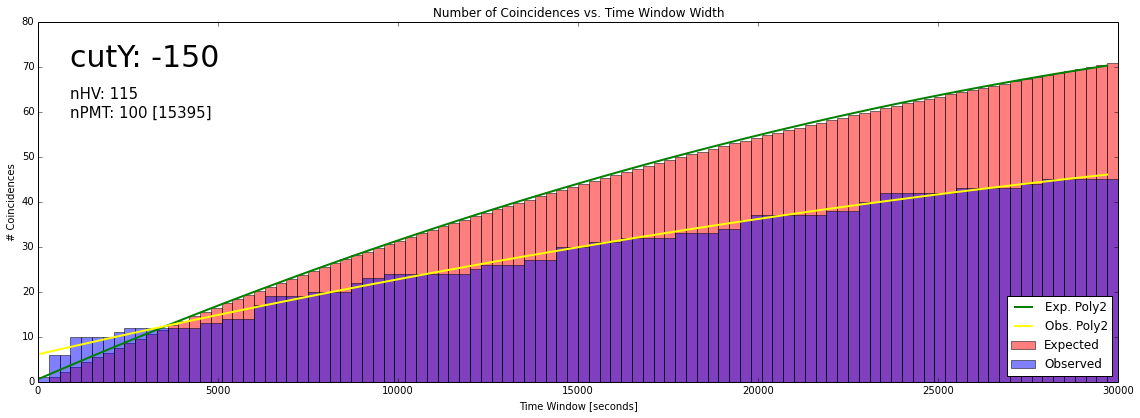

In [9]:
maxWindow = 30000
step = maxWindow/100

numC = array.array("I",[])
tWindow = array.array("d",[])
probC = array.array("d",[])
aveC = array.array("d",[])

for t in np.arange(5,maxWindow,step):
    timeC = array.array("d",[])
    deltaC = array.array("d",[])
    for i,timestampHV in enumerate(timeHV):
        for j,timestampPMT in enumerate(timeCutPMT):
            deltaT = timestampPMT-timestampHV
            if abs(deltaT) < t:
                timeC.append(timestampHV)
                deltaC.append(deltaT)

    nCoinc = len(timeC)
    tWindow.append(float(t))
    numC.append(nCoinc)
    probC.append(prob.prob3(nMonths,t,nHV,nPMT,nCoinc)*100)
    aveC.append(prob.average3(nMonths,t,nHV,nPMT))

z1 = np.polyfit(tWindow,aveC,2)
p1 = np.poly1d(z1)
z2 = np.polyfit(tWindow,numC,2)
p2 = np.poly1d(z2)  

fig = plt.figure(figsize=(15,5), dpi=80)
ax = fig.add_axes([0,0,1,1])
plt.bar(tWindow,aveC,step,color="red",alpha=0.5,label='Expected')
plt.bar(tWindow,numC,step,color="blue",alpha=0.5,label='Observed')
plt.plot(tWindow,p1(tWindow),"green",linewidth=2,label='Exp. Poly2')
plt.plot(tWindow,p2(tWindow),"yellow",linewidth=2,label='Obs. Poly2')
plt.text(.03, .9,"cutY: %.f" %cutY, ha='left', va='center',fontsize=30,transform=ax.transAxes)
plt.text(.03, .8,"nHV: %.f" %nHV, ha='left', va='center',fontsize=15,transform=ax.transAxes)
plt.text(.03, .75,"nPMT: %.f [%.f]" %(nPMT,len(timePMT)), ha='left', va='center',fontsize=15,transform=ax.transAxes)

plt.legend(loc='lower right', frameon=True)
plt.title("Number of Coincidences vs. Time Window Width")
plt.xlabel('Time Window [seconds]')
plt.ylabel('# Coincidences')
plt.xlim(0,maxWindow)
# plt.ylim(0,30)
plt.savefig('demo.png', transparent=False)

plt.show()